In [ ]:
import sys
import pickle
import string
import operator

import nltk
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

from wordcloud import WordCloud, ImageColorGenerator
from matplotlib.ticker import PercentFormatter
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from google.colab import drive
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF


In [ ]:
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
data_path = Path('drive/MyDrive/Datathon2022/data/')
img_path = Path('drive/MyDrive/Datathon2022/img/')

In [ ]:
!ls drive/MyDrive/Datathon2022/data/

'adapted_public - adapted_public.csv'   evaluation_public_4.csv
 adapted_public.csv		        evaluation_public.csv
 adapted_public.gsheet		        evaluation_sample.csv
 augmented.csv			        labels_racism.csv
 augmented.pickle		        mostcommon.pickle
 augmented_tweets.csv		        paper_input_tweets.csv
 augmented_tweets.gsheet	        roberta_predictions.csv
 augmented_tweets.xlsx		        roberta_predictions_public.csv
 df_aug_lbl.pickle		        roberta_predictions_sample.csv
 df_final.pickle		        spanish_stopwords.txt
 df_paper.pickle		        tweets_2022_03_26-11_23_29_PM.json
 df_public.pickle		        tweets_2022_03_26-11_42_36_PM.json
 df_test.pickle			        tweets_2022_03_26-11_48_44_PM.json
 df_train.pickle		        tweets_2022_03_27-02_25_01_PM.json
 evaluation_final_comparation.csv       tweets_2022_03_28-12_28_14_AM.json
 evaluation_final.csv		        tweets_lookup_terms.pickle


## Loading Preprocessed data

In [ ]:
df_train = pd.read_pickle(Path(data_path, 'df_train.pickle'))
df_paper = pd.read_pickle(Path(data_path, 'df_paper.pickle'))

## Obtaining tables

In [ ]:
df_pct_flsl = df_train.groupby(['final_label','support_label'], as_index=False).size()
df_pct_flsl['prop'] = df_pct_flsl['size'] / df_pct_flsl['size'].sum() * 100
df_pct_flsl 

,final_label,support_label,size,prop
0,non-racist,mild,215,3.790550
1,non-racist,strong,2495,43.988011
2,racist,mild,498,8.779972
3,racist,strong,2278,40.162200
4,unknown,strong,186,3.279267


## Drawing plots

**Histogram of tweets size**

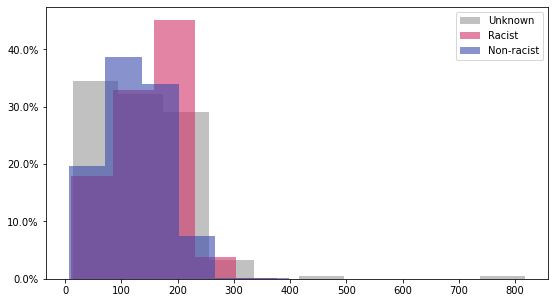

In [ ]:

alp = 0.6

df_ukn = df_train[df_train.final_label=='unknown'].copy()
df_rac = df_train[df_train.final_label=='racist'].copy()
df_non = df_train[df_train.final_label=='non-racist'].copy()
plt.figure(figsize=(9,5))
plt.hist(df_ukn['tweet_len'], color=colors[2], alpha=alp, weights=np.ones(len(df_ukn['tweet_len'])) / len(df_ukn['tweet_len']))
plt.hist(df_rac['tweet_len'], color=colors[0], alpha=alp, weights=np.ones(len(df_rac['tweet_len'])) / len(df_rac['tweet_len']))
plt.hist(df_non['tweet_len'], color=colors[1], alpha=alp, weights=np.ones(len(df_non['tweet_len'])) / len(df_non['tweet_len']))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(['Unknown','Racist','Non-racist'])
plt.savefig(Path(img_path, 'hist_tweets.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Exploratory analysis

**BCN Analytics**

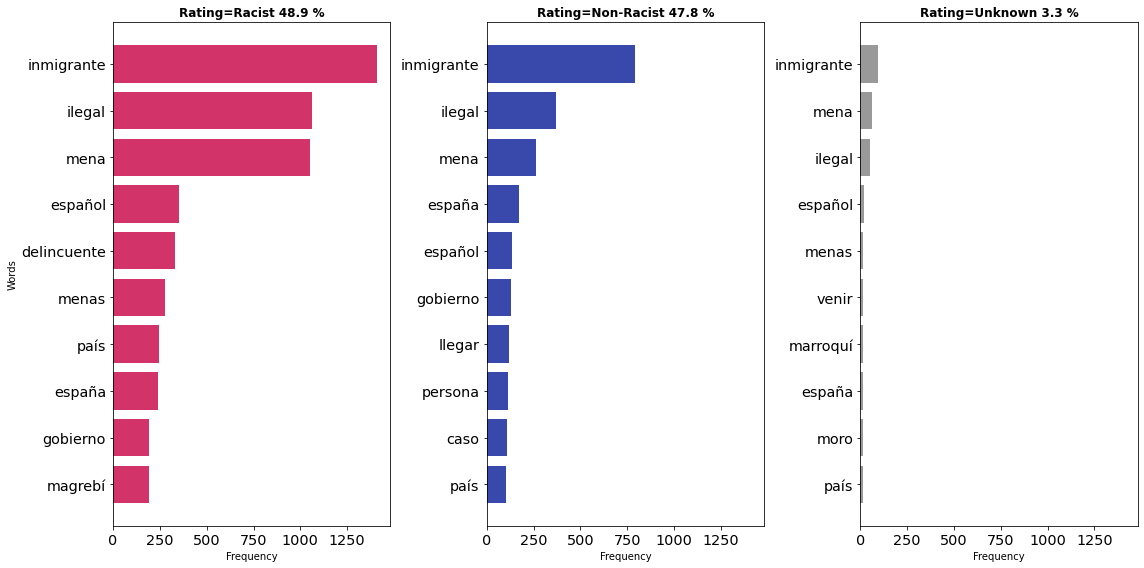

In [ ]:
df_pct = df_train.groupby(['final_label'], as_index=False).size()

df_pct = df_pct['size'] / df_pct['size'].sum() * 100
df_pct = df_pct.to_list()

colors = ['#d23369', '#3949ab', '#999999']

num_freq = 10
group_by = df_train.groupby('final_label')['lemma_spacy_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(num_freq))
group_by_nr = group_by.iloc[0]
words_nr = list(zip(*group_by_nr))[0]
freq_nr = list(zip(*group_by_nr))[1]

group_by = df_train.groupby('final_label')['lemma_spacy_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(num_freq))
group_by_ra = group_by.iloc[1]
words_ra = list(zip(*group_by_ra))[0]
freq_ra = list(zip(*group_by_ra))[1]

group_by = df_train.groupby('final_label')['lemma_spacy_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(num_freq))
group_by_un = group_by.iloc[2]
words_un = list(zip(*group_by_un))[0]
freq_un = list(zip(*group_by_un))[1]

fig, axs = plt.subplots(1, 3, figsize=(16,8), sharex=True)

axs[0].barh(words_ra, freq_ra, color=colors[0])
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Words')
axs[0].tick_params(labelsize='x-large')
axs[0].invert_yaxis()
axs[0].set_title(f'Rating=Racist {df_pct[1]:.1f} %', fontweight='bold')

axs[1].barh(words_nr, freq_nr, color=colors[1])
axs[1].set_xlabel('Frequency')
axs[1].tick_params(labelsize='x-large')
axs[1].invert_yaxis()
axs[1].set_title(f'Rating=Non-Racist {df_pct[0]:.1f} %', fontweight='bold')

axs[2].barh(words_un, freq_un, color=colors[2])
axs[2].set_xlabel('Frequency')
axs[2].tick_params(labelsize='x-large')
axs[2].invert_yaxis()
axs[2].set_title(f'Rating=Unknown {df_pct[2]:.1f} %', fontweight='bold')


fig.tight_layout()
plt.savefig(Path(img_path, 'freq_bcn_analytic.png'), bbox_inches='tight')
plt.show()


**BETO**

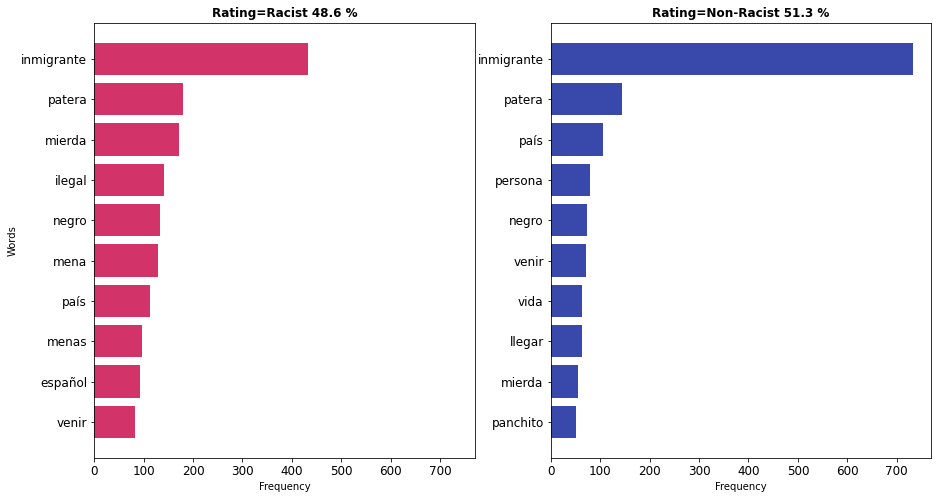

In [ ]:
df_pct = df_paper.groupby(['label'], as_index=False).size()

df_pct = df_pct['size'] / df_pct['size'].sum() * 100
df_pct = df_pct.to_list()

num_freq = 10
group_by = df_paper.groupby('label')['lemma_spacy_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(num_freq))
group_by_nr = group_by.iloc[0]
words_nr = list(zip(*group_by_nr))[0]
freq_nr = list(zip(*group_by_nr))[1]

group_by = df_paper.groupby('label')['lemma_spacy_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(num_freq))
group_by_ra = group_by.iloc[1]
words_ra = list(zip(*group_by_ra))[0]
freq_ra = list(zip(*group_by_ra))[1]

fig, axs = plt.subplots(1, 2, figsize=(15,8), sharex=True)

axs[0].barh(words_ra, freq_ra, color=colors[0])
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Words')
axs[0].tick_params(labelsize='large')
axs[0].invert_yaxis()
axs[0].set_title(f'Rating=Racist {df_pct[1]:.1f} %', fontweight='bold')

axs[1].barh(words_nr, freq_nr, color=colors[1])
axs[1].set_xlabel('Frequency')
axs[1].tick_params(labelsize='large')
axs[1].invert_yaxis()
axs[1].set_title(f'Rating=Non-Racist {df_pct[0]:.1f} %', fontweight='bold')

plt.savefig(Path(img_path, 'freq_betodataset.png'), bbox_inches='tight')
plt.show()

### Wordclouds

**Cover with most common words**

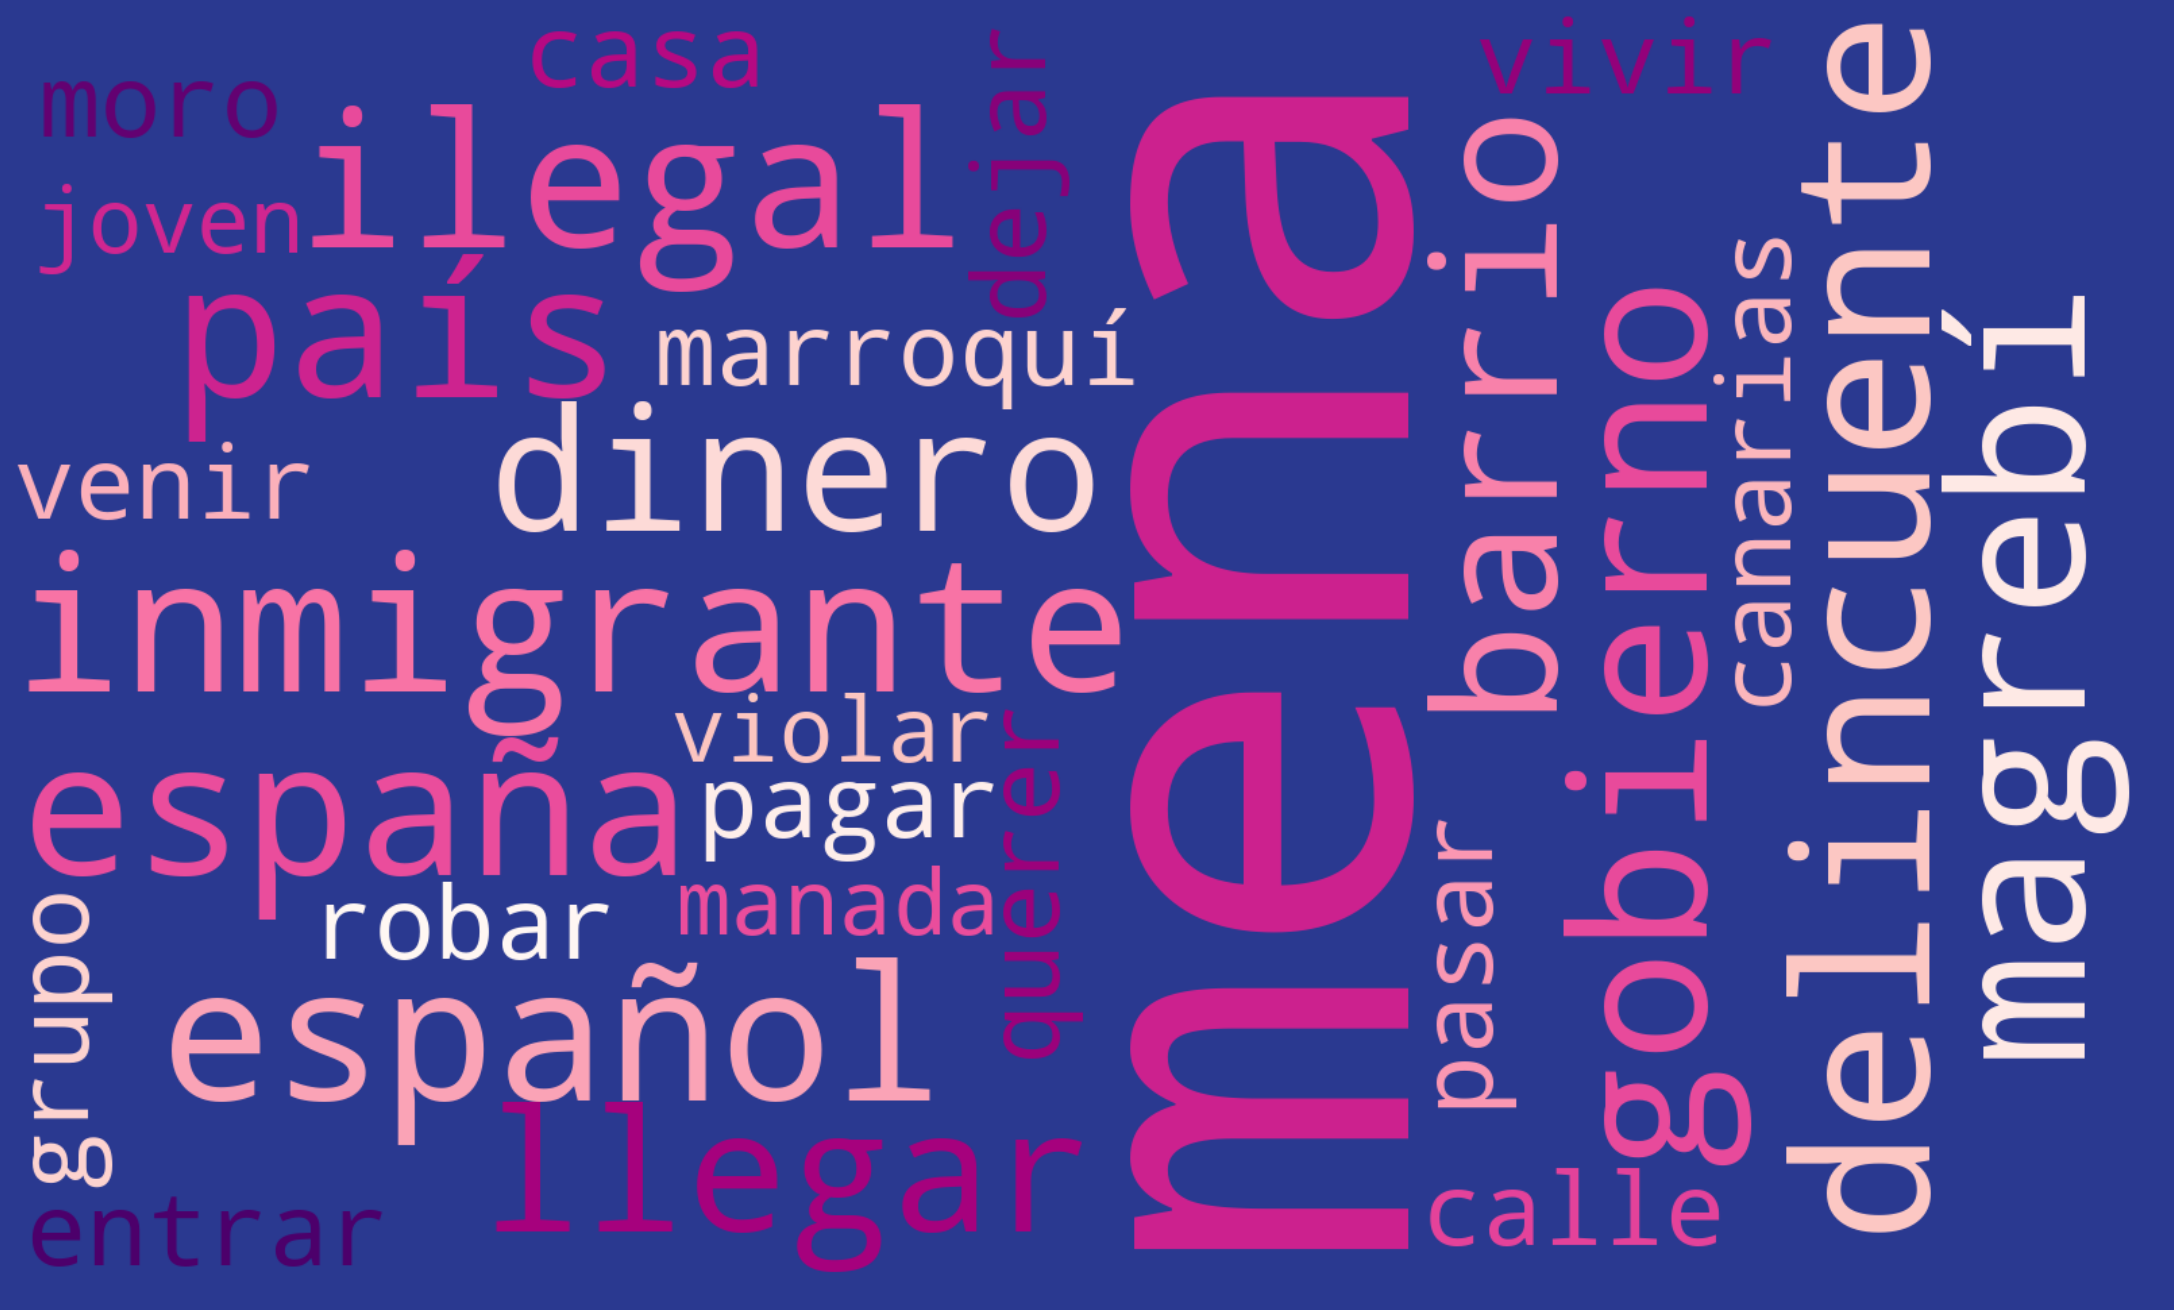

In [ ]:
words = df_train['lemma_spacy'][df_train['final_label']=='racist']
allwords = []
for wordlist in words:
    allwords += wordlist
mostcommon = FreqDist(allwords).most_common(30)

wordcloud = WordCloud(width=1600, height=960, background_color='#2a3990', colormap='RdPu_r').generate(str(mostcommon).replace("'",""))

fig = plt.figure(figsize=(30,30), facecolor='#2a3990', edgecolor='#2a3990')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig(Path(img_path, 'wordcloud1.png'), bbox_inches='tight',edgecolor=fig.get_edgecolor())
plt.show()

**Most common hashtags in racist tweets**

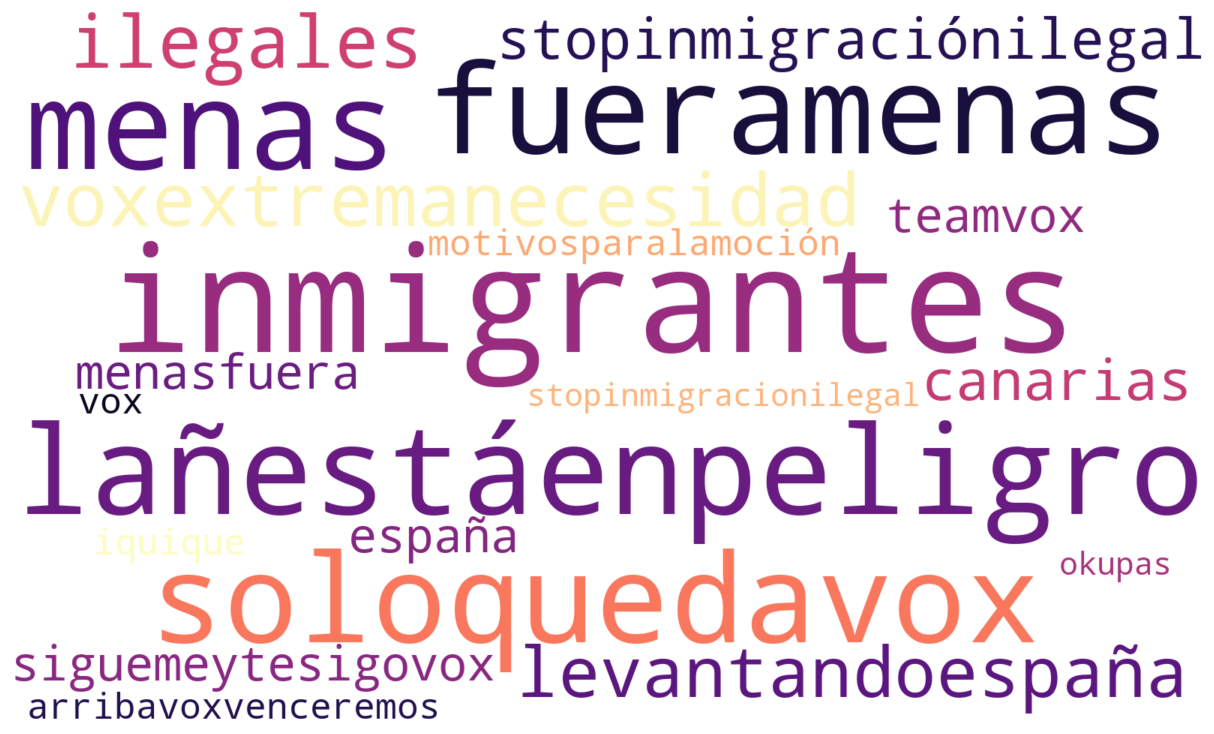

In [ ]:
words = df_train['stopwords_removed'][df_train['final_label']=='racist']
allwords = []
for wordlist in words:
    for word in wordlist:
      if word[0] == '#':
        allwords.append(word)
mostcommon = FreqDist(allwords).most_common(20)
wordcloud = WordCloud(width=1600, height=960, background_color='white', colormap='magma').generate(str(mostcommon).replace("'",""))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig(Path(img_path, 'wordcloud2.png'), bbox_inches='tight')
plt.show()

## Models

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df_clean[df_clean['final_label'] =='racist']['lemma_spacy_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 5
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
mena menas dinero barrio mantener
Topic 1:
mena españolar pagar vivir menas
Topic 2:
inmigrante ilegal delincuente mena etcétera
Topic 3:
inmigrante ilegal llegar canarias país
Topic 4:
mena magrebí inmigrante marroquí violar


In [ ]:
nmf = NMF(n_components=5, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
inmigrante ilegal llegar canarias entrar
Topic 1:
mena españolar pagar barrio dinero
Topic 2:
menas dinero mantener españa españolar
Topic 3:
delincuente país chile venezolano okupa
Topic 4:
magrebí violar marroquí chico paliza


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


Export most common words

In [ ]:
pos_words = df_clean['wordnet_pos']
all_pos_words = []
for pos_wordlist in pos_words:
    all_pos_words += pos_wordlist
most_common_pos = FreqDist(all_pos_words).most_common(100)

In [ ]:
words = df_train['lemma_spacy'][df_train['final_label']=='racist']
allwords = []
for wordlist in words:
    allwords += wordlist

def lookup_word(palabras_busca,lista_input):
  lista = []
  for item in palabras_busca:
    lista = lista + [(key,value) for key, value in lista_input.items() if item in key.lower()]
  return lista

racist_words = FreqDist(allwords)
chile = lookup_word(['chile'],racist_words)
venezuela = lookup_word(['venez'],racist_words)
ecuador = lookup_word(['ecuat','ecuador'],racist_words)
rumania = lookup_word(['ruman'],racist_words)
argentina = lookup_word(['argent'],racist_words)
colombia = lookup_word(['colom'],racist_words)
peru = lookup_word(['peru'],racist_words)
bolivia = lookup_word(['boliv'],racist_words)
brasil = lookup_word(['brasi'],racist_words)
marruecos = lookup_word(['magre','marru','marro'],racist_words)
gitanos = lookup_word(['gitan'],racist_words)
judios = lookup_word(['judio','judia','judí'],racist_words)
pakistan = lookup_word(['paki','paqui'],racist_words)
etnicos = lookup_word(['negro', 'moreno','color','negr'],racist_words)
africa =  lookup_word(['moro','afric'],racist_words)
latinos = lookup_word(['panchito','pancho','pancha','latin','americ', 'sudaca'],racist_words)
vox = lookup_word(['vox'],racist_words)
covid = lookup_word(['pandemia', 'covid', 'corona', 'enfermidad'],racist_words)
mexico = lookup_word(['mexi'],racist_words)
dominicanos = lookup_word(['domini'],racist_words)

list_temas = {}
list_temas['chile']          = sum(x[1] for x in chile)
list_temas['venezuela'] = sum(x[1] for x in venezuela)
list_temas['ecuador'] = sum(x[1] for x in ecuador)
list_temas['rumania'] = sum(x[1] for x in rumania)
list_temas['argentina'] = sum(x[1] for x in argentina)
list_temas['colombia'] = sum(x[1] for x in colombia)
list_temas['peru'] = sum(x[1] for x in peru)
list_temas['bolivia'] = sum(x[1] for x in bolivia)
list_temas['brasil'] = sum(x[1] for x in brasil)
list_temas['marruecos'] = sum(x[1] for x in marruecos)
list_temas['gitanos'] = sum(x[1] for x in gitanos)
list_temas['judios'] = sum(x[1] for x in judios)
list_temas['pakistan'] = sum(x[1] for x in pakistan)
list_temas['etnicos'] = sum(x[1] for x in etnicos)
list_temas['vox'] = sum(x[1] for x in vox)
list_temas['covid'] = sum(x[1] for x in covid)
list_temas['mexico'] = sum(x[1] for x in mexico)
list_temas['dominicanos'] = sum(x[1] for x in dominicanos)
list_temas['africa'] = sum(x[1] for x in africa)
list_temas['latinos'] = sum(x[1] for x in latinos)
list_temas= sorted(list_temas.items(), key=operator.itemgetter(1)) 
list_temas=dict(list_temas)

{'mexico': 4, 'ecuador': 6, 'argentina': 6, 'judios': 8, 'brasil': 9, 'dominicanos': 9, 'bolivia': 12, 'peru': 17, 'pakistan': 17, 'colombia': 20, 'rumania': 53, 'gitanos': 62, 'covid': 64, 'venezoela': 73, 'vox': 106, 'latinos': 136, 'etnicos': 156, 'chile': 161, 'africa': 185, 'marruecos': 523}


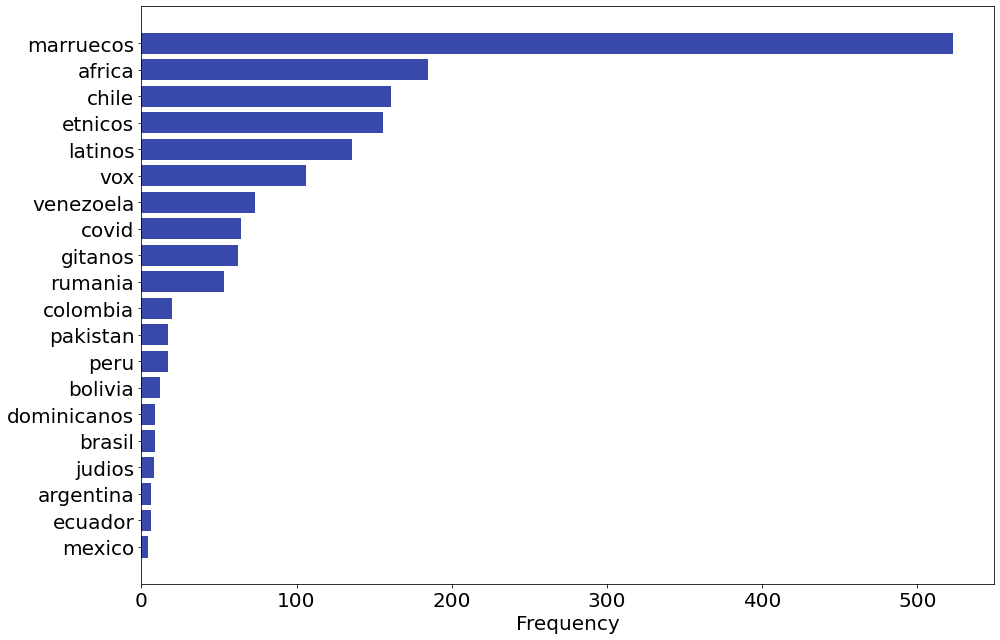

In [ ]:
plt.figure(figsize=(14,9))
plt.barh(range(len(list_temas)), list(list_temas.values()), align='center', color=colors[1])
plt.yticks(range(len(list_temas)), list(list_temas.keys()))
plt.xlabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.tight_layout()
plt.savefig(Path(img_path, 'racist_words.png'), bbox_inches='tight', dpi=300)
plt.show()